# PA3 CNN for Semantic Segmentation

Deliverables:
- Avg pixel accuracy. (Boundary is exclusive)
- Avg IoU. (Boundary is exclusive)

## 1 Get and Inspect Data

In [ ]:
!python download.py

In [ ]:
import torch
from util import *
from voc import *
from torch.utils.data import DataLoader
from torchvision.transforms import *

'''
Image shape : (224, 224, 3)
Num samples : train 209, val 213, test 210
Num classes : 21
Images are in range (0,1)
Masks have values {0,1}
'''
loader = DataLoader(VOC('train') , batch_size=5, shuffle=False)
images, masks = next(iter(loader)) # (B, 3, H, W), (B, H, W)
images = images.detach().numpy()
masks = masks.detach().numpy()

anns = []
for mask in masks:
    classes = []
    for label in np.unique(mask):
        classes.append(f'{label}: ' + class_dict()[label]) 
    anns.append("\n".join(classes))
plot_images(images)
plot_images(masks, pallet=voc_pallet(), annotations=anns)

## 2 Implement Evaluation Metric: IoU and Pixel acc.

In [1]:
from util import *
from voc import *
from torch.utils.data import DataLoader
from torchvision.transforms import *

dataset = VOC('train')
img, mask = dataset.__getitem__(0)

iou = compute_iou(np.zeros((224,224)), mask)
acc = compute_pixel_acc(np.zeros((224,224)), mask)
print(f'IoU: {iou}, Acc: {acc}')

hi1s 50176
IoU: 0.3199869791666667, Acc: 0.9599609375


## 3 Baseline Model
- Optim: Adam / Adamw
- Use early stoppling
- Desired result: 0.65 acc, 0.005 IoU

Training model [baseFCN] on device [cuda]


Epoch 20:  95%|█████████▌| 19/20 [00:43<00:02,  2.30s/it, Train Loss: 1.32 Val Loss: 2.14 | Val IoU: 0.06. Val acc: 0.7] 



Early stop at epoch 14.

Test IOU: 0.062. Test acc: 0.68


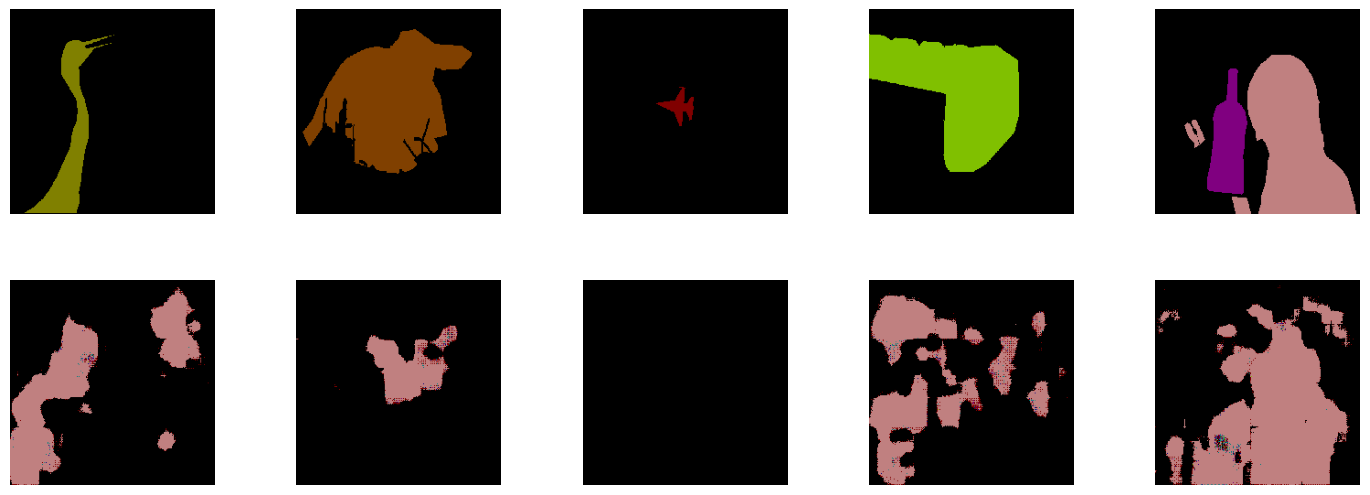

In [2]:
from util import *
from voc import *
from model import *
from train import *

import torchvision.transforms

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = {
    'epochs'    : 20,
    'bz'        : 16,
    'lr'        : 5e-4,
    'device'    : device,
    'early_stop': 5,
    'remark'    : 'baseFCN'
}

# Transformations
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*mean_std)
    ])
target_transform = MaskToTensor()
TF_transform = None

# Dataset and Dataloader initialization
train_loader, val_loader, test_loader = get_train_val_test_loader(
    input_transform, target_transform, TF_transform, config['device'], config['bz'])

''' Prepare model '''
fcn_model = FCN_baseline(n_class=21)
fcn_model.apply(init_weights)
fcn_model = fcn_model.to(config['device'])

optimizer = torch.optim.Adam(fcn_model.parameters(), config['lr'])
criterion =  torch.nn.CrossEntropyLoss()

''' Train model '''
best_iou_score, best_accuracy, min_validation_loss, \
training_loss_history, validation_loss_history, early_stop_epoch \
    = train(fcn_model, train_loader, val_loader, criterion, optimizer, config)

''' Test model '''
_, iou, acc = val(fcn_model, test_loader, criterion)
print(f'Test IOU: {round(iou, 3)}. Test acc: {round(acc, 3)}')

''' Visualize some test sample '''
imgs, masks_gt = next(iter(test_loader))
imgs, masks_gt = imgs[:5], masks_gt[:5]
masks_gt = F.one_hot(masks_gt.to(torch.int64), num_classes=21).permute(0, 3, 1, 2).to(torch.float64)
masks_pred = fcn_model(imgs)
masks_pred = torch.argmax(masks_pred, dim=1).cpu().numpy()
masks_gt = torch.argmax(masks_gt, dim=1).cpu().numpy()
plot_images(np.concatenate([masks_gt,masks_pred]), voc_pallet())

## 4 Improve Baseline Model
- LR schedule: cosine annealing
- Augment dataset: flip, rotate, crop
- Address class imbalance issue with modified loss

Training model [modifiedFCN] on device [cuda]


Epoch 14:  65%|██████▌   | 13/20 [00:51<00:27,  3.94s/it, Train Loss: 2.8 Val Loss: 3.3 | Val IoU: 0.02. Val acc: 0.08]  



Early stop at epoch 8.

Test IOU: 0.015. Test acc: 0.059


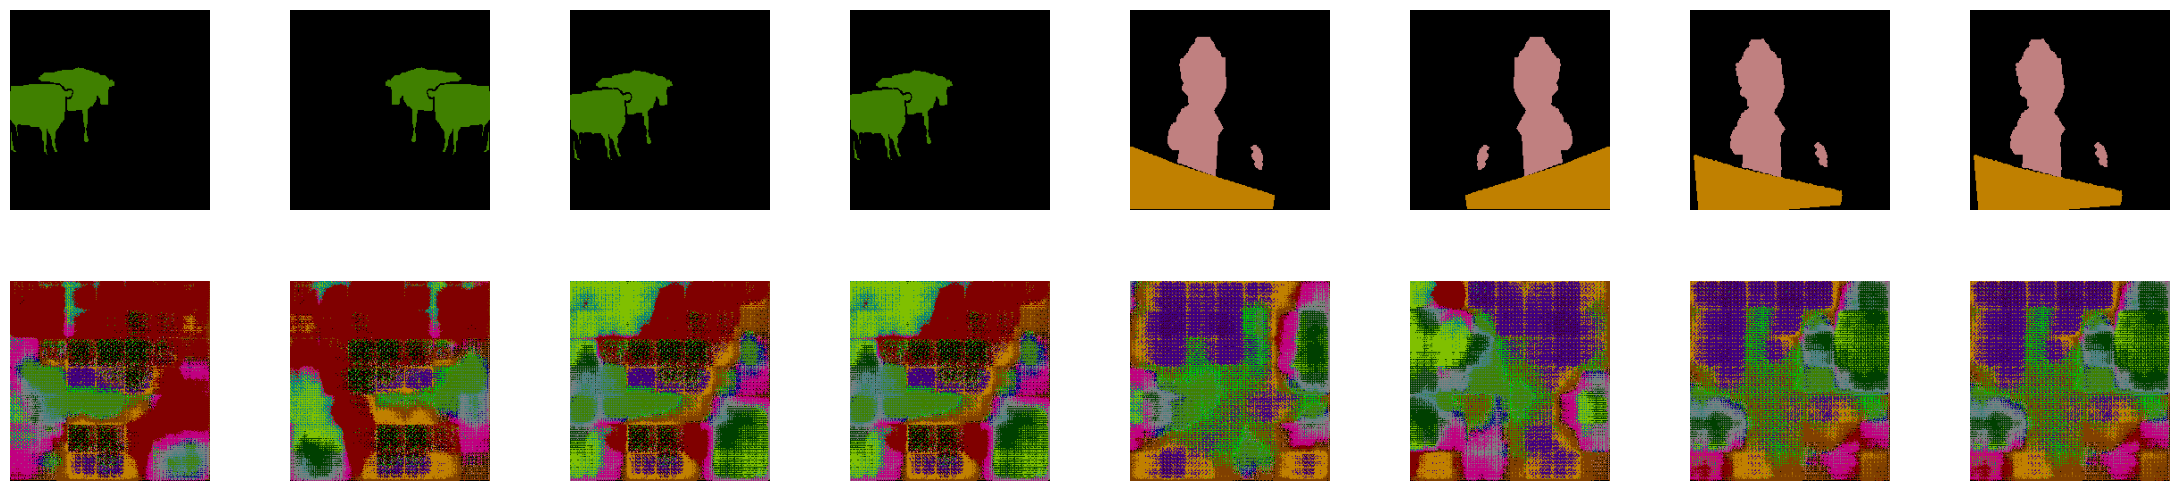

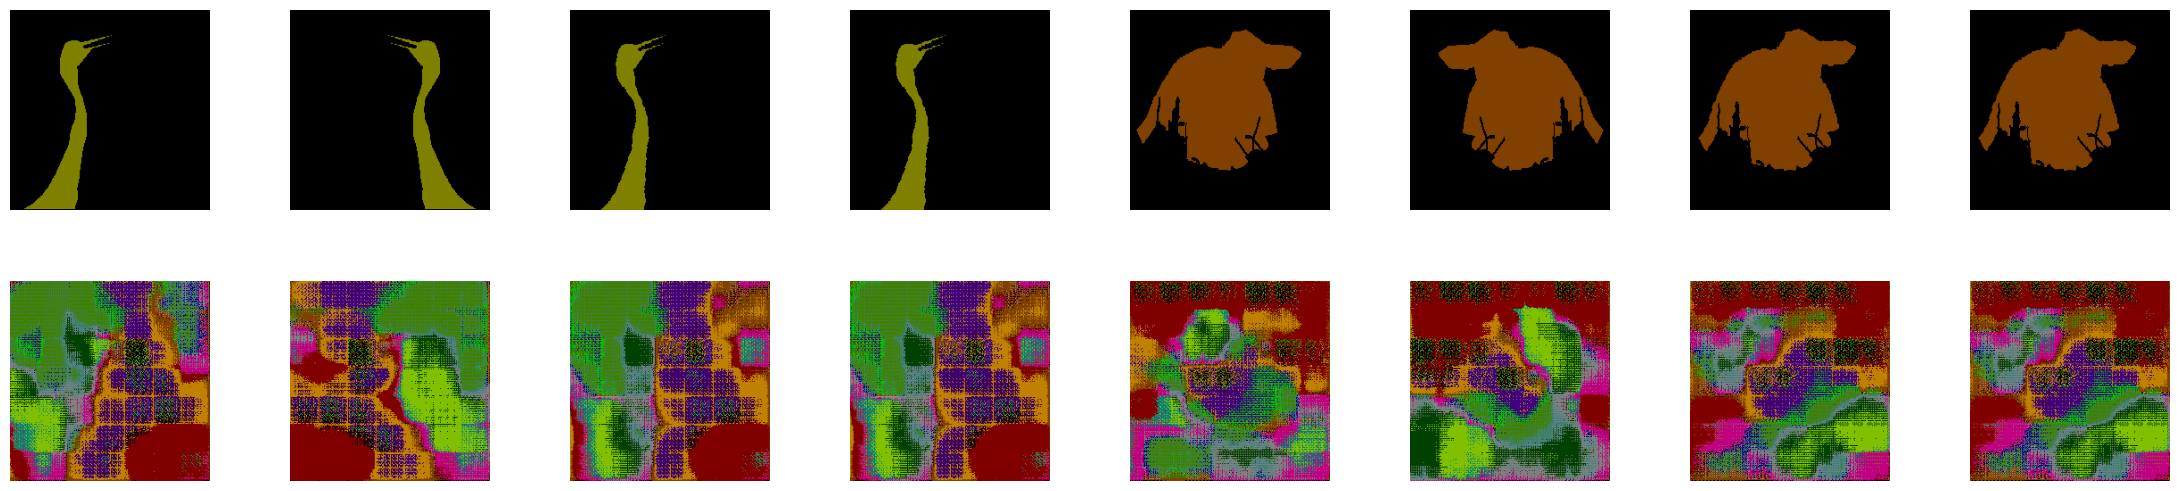

In [4]:
from util import *
from voc import *
from model import *
from train import *
import torchvision.transforms.functional as TF

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = {
    'epochs'    : 20,
    'bz'        : 16,
    'lr'        : 1e-3,
    'device'    : device,
    'early_stop': 5,
    'remark'    : 'modifiedFCN'
}

''' Transformations '''
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])
target_transform = MaskToTensor()
TF_transform = lambda x: [x, TF.hflip(x), TF.rotate(x.unsqueeze(0), angle = 5, fill = 0).squeeze(0), TF.rotate(x.unsqueeze(0), angle = 5, fill = 0).squeeze(0)]

''' Data loaders '''
train_loader, val_loader, test_loader = get_train_val_test_loader(
    input_transform, target_transform, TF_transform, config['device'], config['bz'], collate_fn=collate_fn)

''' Prepare model '''
fcn_model = FCN_baseline()
fcn_model.apply(init_weights)
fcn_model = fcn_model.to(device)

optimizer = torch.optim.Adam(fcn_model.parameters(), config['lr'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['epochs'], eta_min = 0.0001)

class_weight = getClassWeights(input_transform, target_transform, TF_transform)
criterion =  torch.nn.CrossEntropyLoss(weight = class_weight)

''' Train model '''
best_iou_score, best_accuracy, min_validation_loss, \
training_loss_history, validation_loss_history, early_stop_epoch \
    = train(fcn_model, train_loader, val_loader, criterion, optimizer, config)

''' Test model '''
_, iou, acc = val(fcn_model, test_loader, criterion)
print(f'Test IOU: {round(iou, 3)}. Test acc: {round(acc, 3)}')

''' Visualize some test sample '''
imgs, masks_gt = next(iter(train_loader))
imgs, masks_gt = imgs[:8], masks_gt[:8]
masks_gt = F.one_hot(masks_gt.to(torch.int64), num_classes=21).permute(0, 3, 1, 2).to(torch.float64)
masks_pred = fcn_model(imgs)
masks_pred = torch.argmax(masks_pred, dim=1).cpu().numpy()
masks_gt = torch.argmax(masks_gt, dim=1).cpu().numpy()
plot_images(np.concatenate([masks_gt,masks_pred]), voc_pallet(), cols=8)

imgs, masks_gt = next(iter(test_loader))
imgs, masks_gt = imgs[:8], masks_gt[:8]
masks_gt = F.one_hot(masks_gt.to(torch.int64), num_classes=21).permute(0, 3, 1, 2).to(torch.float64)
masks_pred = fcn_model(imgs)
masks_pred = torch.argmax(masks_pred, dim=1).cpu().numpy()
masks_gt = torch.argmax(masks_gt, dim=1).cpu().numpy()
plot_images(np.concatenate([masks_gt,masks_pred]), voc_pallet(), cols=8)

## 5 Experiments: Other architectures

### a) New Architecture
* Alter number of layers, activation function, and dimension of filters

In [19]:
from util import *
from voc import *
from model import *
from train import *
import torchvision.transforms

def test_activation(activation, remark):
    device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    config = {
        'epochs'    : 20,
        'bz'        : 16,
        'lr'        : 5e-4,
        'device'    : device,
        'early_stop': 5,
        'remark'    : remark
    }

    # Transformations
    mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    input_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(*mean_std)
        ])
    target_transform = MaskToTensor()
    TF_transform = None

    # Dataset and Dataloader initialization
    train_loader, val_loader, test_loader = get_train_val_test_loader(
        input_transform, target_transform, TF_transform, config['device'], config['bz'])

    ''' Prepare model '''
    fcn_model = FCN_baseline(n_class=21, activation=activation)
    fcn_model.apply(init_weights)
    fcn_model = fcn_model.to(config['device'])

    optimizer = torch.optim.Adam(fcn_model.parameters(), config['lr'])
    criterion =  torch.nn.CrossEntropyLoss()

    ''' Train model '''
    best_iou_score, best_accuracy, min_validation_loss, \
    training_loss_history, validation_loss_history, early_stop_epoch \
        = train(fcn_model, train_loader, val_loader, criterion, optimizer, config)

    ''' Test model '''
    _, iou, acc = val(fcn_model, test_loader, criterion)
    print(f'Test IOU: {round(iou, 3)}. Test acc: {round(acc, 3)}')

#     ''' Visualize some test sample '''
#     imgs, masks_gt = next(iter(test_loader))
#     imgs, masks_gt = imgs[:5], masks_gt[:5]
#     masks_gt = F.one_hot(masks_gt.to(torch.int64), num_classes=21).permute(0, 3, 1, 2).to(torch.float64)
#     masks_pred = fcn_model(imgs)
#     masks_pred = torch.argmax(masks_pred, dim=1).cpu().numpy()
#     masks_gt = torch.argmax(masks_gt, dim=1).cpu().numpy()
#     plot_images(np.concatenate([masks_gt,masks_pred]), voc_pallet())

In [20]:
# Test activation functions to find which yields best performance
test_activation(nn.ReLU, 'ReLU')
test_activation(nn.LeakyReLU, 'LeakyReLU')
test_activation(nn.Tanh, 'Tanh')
test_activation(nn.Softmax, 'Softmax')
test_activation(nn.Sigmoid, 'Sigmoid')

Training model [ReLU] on device [cuda]


Epoch 14:  65%|██████▌   | 13/20 [01:11<00:38,  5.49s/it, Train Loss: 1.27 Val Loss: 2.15 | Val IoU: 0.06. Val acc: 0.69]



Early stop at epoch 8.

Test IOU: 0.062. Test acc: 0.67
Training model [LeakyReLU] on device [cuda]


Epoch 11:  50%|█████     | 10/20 [00:56<00:56,  5.67s/it, Train Loss: 1.48 Val Loss: 2.38 | Val IoU: 0.06. Val acc: 0.69]



Early stop at epoch 5.

Test IOU: 0.061. Test acc: 0.662
Training model [Tanh] on device [cuda]


Epoch 8:  35%|███▌      | 7/20 [00:40<01:15,  5.82s/it, Train Loss: 2.3 Val Loss: 3.2 | Val IoU: 0.05. Val acc: 0.48]  



Early stop at epoch 2.

Test IOU: 0.043. Test acc: 0.424
Training model [Softmax] on device [cuda]


Epoch 13:  60%|██████    | 12/20 [01:07<00:45,  5.64s/it, Train Loss: 0.97 Val Loss: 1.45 | Val IoU: 0.06. Val acc: 0.73]



Early stop at epoch 7.

Test IOU: 0.063. Test acc: 0.706
Training model [Sigmoid] on device [cuda]


Epoch 9:  40%|████      | 8/20 [00:46<01:09,  5.79s/it, Train Loss: 2.94 Val Loss: 3.8 | Val IoU: 0.06. Val acc: 0.55] 



Early stop at epoch 3.

Test IOU: 0.054. Test acc: 0.514


**<center>Performance of Model by Actication Function: Trials 1 - 2 - 3 - Average:</center>**

|Activation|IoU (1)|Acc (1)|   |IoU (2)|Acc (2)|   |IoU (3)|Acc (3)|  \| | | IoU (Avg)|Acc (Avg)|
|:----------|-------------|------|  |-------------|------|-|-------------|------|- |-------------|:------:|:---: |
|Softmax    | 0.062|0.689| | 0.060  |0.687|| 0.063|0.706|\| | | 0.0612| 0.694|
|ReLU      | 0.064|0.676| | 0.063|0.660|| 0.062|0.670|\| | |0.0630 | 0.669|
|LeakyReLU |0.062|0.679|   |0.061|0.607||0.061|0.662|\| | | 0.0614|0.648 |
| Sigmoid     |0.058  |0.604| |0.062 |0.689| |0.054|0.514|\| | |0.0580 | 0.602|
| Tanh     |  0.063|0.665| |  0.062|0.597||  0.043|0.424|\| | |0.0560 | 0.562|

<br>
<center>Softmax has the highest accuracy, so new architecture uses softmax rather than ReLU</center>

Training model [newArchitecture] on device [cuda]


Epoch 35: 100%|██████████| 35/35 [05:45<00:00,  9.86s/it, Train Loss: 1.24 Val Loss: 1.32 | Val IoU: 0.06. Val acc: 0.75]


Test IOU: 0.06. Test acc: 0.725


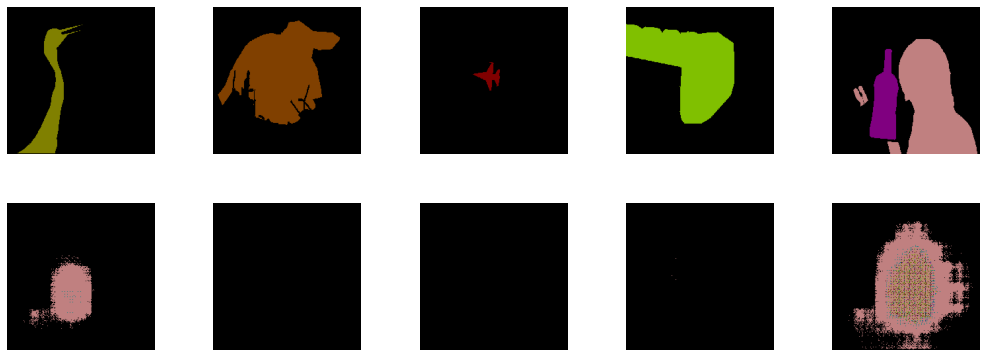

In [3]:
from util import *
from voc import *
from model import *
from train import *
import torchvision.transforms

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = {
    'epochs'    : 35,
    'bz'        : 16,
    'lr'        : 5e-4,
    'device'    : device,
    'early_stop': 5,
    'remark'    : 'newArchitecture'
}

# Transformations
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*mean_std)
    ])
target_transform = MaskToTensor()
TF_transform = None

# Dataset and Dataloader initialization
train_loader, val_loader, test_loader = get_train_val_test_loader(
    input_transform, target_transform, TF_transform, config['device'], config['bz'])

''' Prepare model '''
new_model = New_arch(n_class=21)
new_model.apply(init_weights)
new_model = new_model.to(config['device'])

optimizer = torch.optim.Adam(new_model.parameters(), config['lr'])
criterion =  torch.nn.CrossEntropyLoss()

''' Train model '''
best_iou_score, best_accuracy, min_validation_loss, \
training_loss_history, validation_loss_history, early_stop_epoch \
    = train(new_model, train_loader, val_loader, criterion, optimizer, config)

''' Test model '''
_, iou, acc = val(new_model, test_loader, criterion)
print(f'Test IOU: {round(iou, 3)}. Test acc: {round(acc, 3)}')

''' Visualize some test sample '''
imgs, masks_gt = next(iter(test_loader))
imgs, masks_gt = imgs[:5], masks_gt[:5]
masks_gt = F.one_hot(masks_gt.to(torch.int64), num_classes=21).permute(0, 3, 1, 2).to(torch.float64)
masks_pred = new_model(imgs)
masks_pred = torch.argmax(masks_pred, dim=1).cpu().numpy()
masks_gt = torch.argmax(masks_gt, dim=1).cpu().numpy()
plot_images(np.concatenate([masks_gt,masks_pred]), voc_pallet())

### b) Transfer Learning 
* Replace the encoder of the given FCN architecture with ResNet34 for Transfer Learning
    * Remove the last fully connected layer and the avgpool layer of ResNet34 to match the dimension of the decoder

Training model [Resnet] on device [cuda]


  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch 18:  60%|██████    | 18/30 [04:54<03:13, 16.17s/it, Train Loss: 1.63 Val Loss: 1.91 | Val IoU: 0.12. Val acc: 0.76]


Early stop at epoch 12.



Epoch 30: 100%|██████████| 30/30 [08:04<00:00, 16.14s/it, Train Loss: 1.19 Val Loss: 1.84 | Val IoU: 0.13. Val acc: 0.73]


Test IOU: 0.096. Test acc: 0.696. Test loss: 2.038


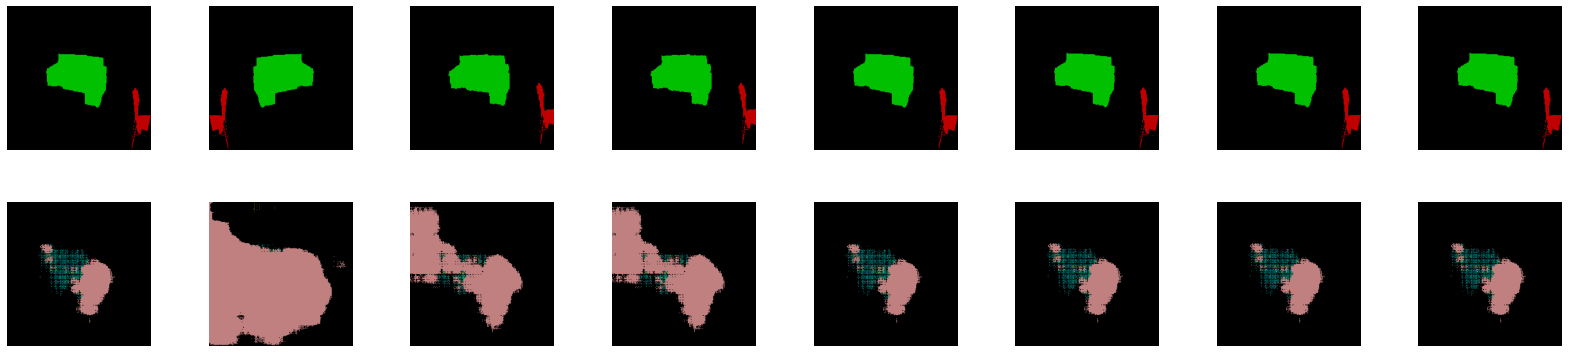

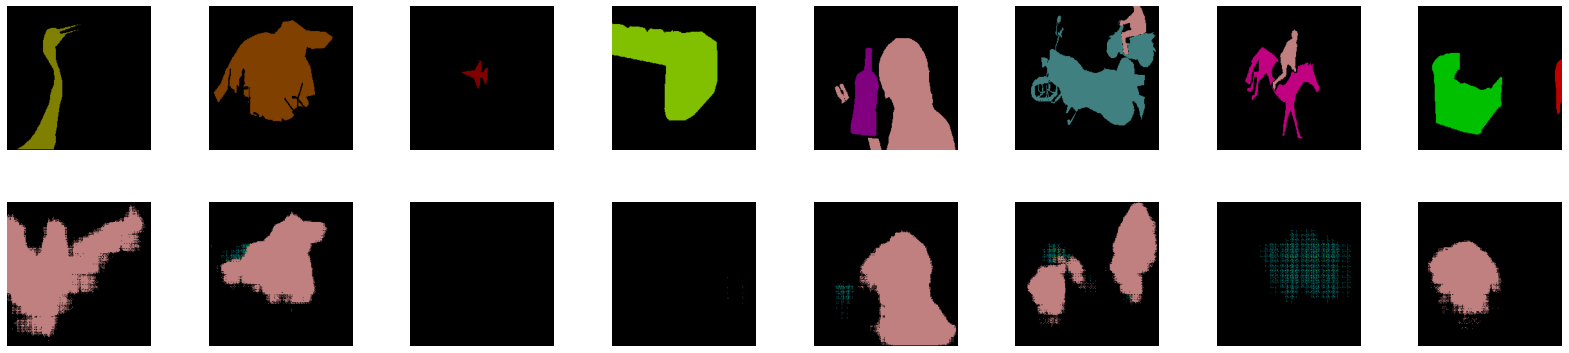

In [1]:
from util import *
from voc import *
from model import *
from train import *
import torchvision.transforms.functional as TF

torch.cuda.empty_cache()

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = {
    'epochs'    : 30,
    'bz'        : 8,
    'lr'        : 1e-3,
    'device'    : device,
    'early_stop': 5,
    'remark'    : 'Resnet'
}

''' Transformations '''
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])
target_transform = MaskToTensor()
TF_transform = lambda x: [x, TF.hflip(x), TF.rotate(x.unsqueeze(0), angle = 5, fill = 0).squeeze(0), TF.rotate(x.unsqueeze(0), angle = 5, fill = 0).squeeze(0), *TF.five_crop(x, (224, 224))]

''' Data loaders '''
train_loader, val_loader, test_loader = get_train_val_test_loader(
    input_transform, target_transform, TF_transform, config['device'], config['bz'], collate_fn=collate_fn)

''' Prepare model '''
rnet_model = Resnet()
#rnet_model.apply(init_weights)
rnet_model = rnet_model.to(device)

optimizer = torch.optim.Adam(rnet_model.parameters(), config['lr'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['epochs'], eta_min = 0.0001)

class_weight = getClassWeights(input_transform, target_transform, TF_transform)
criterion =  torch.nn.CrossEntropyLoss(weight = class_weight)

''' Train model '''
best_iou_score, best_accuracy, min_validation_loss, \
training_loss_history, validation_loss_history, early_stop_epoch \
    = train(rnet_model, train_loader, val_loader, criterion, scheduler, optimizer, config)

''' Test model '''
test_loss, iou, acc = modelTest(rnet_model, test_loader, criterion, early_stop_epoch, config['remark'])
print(f'Test IOU: {round(iou, 3)}. Test acc: {round(acc, 3)}. Test loss: {round(test_loss, 3)}')

''' Visualize some test sample '''
imgs, masks_gt = next(iter(train_loader))
imgs, masks_gt = imgs[:8], masks_gt[:8]
masks_gt = F.one_hot(masks_gt.to(torch.int64), num_classes=21).permute(0, 3, 1, 2).to(torch.float64)
masks_pred = rnet_model(imgs)
masks_pred = torch.argmax(masks_pred, dim=1).cpu().numpy()
masks_gt = torch.argmax(masks_gt, dim=1).cpu().numpy()
plot_images(np.concatenate([masks_gt,masks_pred]), voc_pallet(), cols=8)

imgs, masks_gt = next(iter(test_loader))
imgs, masks_gt = imgs[:8], masks_gt[:8]
masks_gt = F.one_hot(masks_gt.to(torch.int64), num_classes=21).permute(0, 3, 1, 2).to(torch.float64)
masks_pred = rnet_model(imgs)
masks_pred = torch.argmax(masks_pred, dim=1).cpu().numpy()
masks_gt = torch.argmax(masks_gt, dim=1).cpu().numpy()
plot_images(np.concatenate([masks_gt,masks_pred]), voc_pallet(), cols=8)

### c) Implement U-Net

Training model [baseFCN] on device [cuda]


Epoch 20: 100%|██████████| 20/20 [03:21<00:00, 10.10s/it, Train Loss: 2.38 Val Loss: 2.38 | Val IoU: 0.06. Val acc: 0.75]


Test IOU: 0.061. Test acc: 0.731


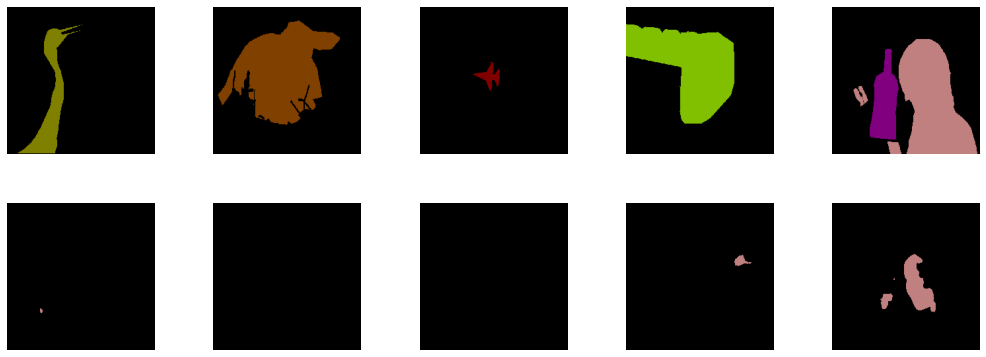

In [6]:
from util import *
from voc import *
from model import *
from train import *

import torchvision.transforms

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = {
    'epochs'    : 20,
    'bz'        : 16,
    'lr'        : 5e-4,
    'device'    : device,
    'early_stop': 5,
    'remark'    : 'U-Net'
}

# Transformations
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*mean_std)
    ])
target_transform = MaskToTensor()
TF_transform = None

# Dataset and Dataloader initialization
train_loader, val_loader, test_loader = get_train_val_test_loader(
    input_transform, target_transform, TF_transform, config['device'], config['bz'])

''' Prepare model '''
unet_model = UNet(n_classes=21)
unet_model = unet_model.to(config['device'])

optimizer = torch.optim.Adam(unet_model.parameters(), config['lr'])
criterion =  torch.nn.CrossEntropyLoss()

''' Train model '''
best_iou_score, best_accuracy, min_validation_loss, \
training_loss_history, validation_loss_history, early_stop_epoch \
    = train(unet_model, train_loader, val_loader, criterion, optimizer, config)

''' Test model '''
_, iou, acc = val(unet_model, test_loader, criterion)
print(f'Test IOU: {round(iou, 3)}. Test acc: {round(acc, 3)}')

''' Visualize some test sample '''
imgs, masks_gt = next(iter(test_loader))
imgs, masks_gt = imgs[:5], masks_gt[:5]
masks_gt = F.one_hot(masks_gt.to(torch.int64), num_classes=21).permute(0, 3, 1, 2).to(torch.float64)
masks_pred = unet_model(imgs)
masks_pred = torch.argmax(masks_pred, dim=1).cpu().numpy()
masks_gt = torch.argmax(masks_gt, dim=1).cpu().numpy()
plot_images(np.concatenate([masks_gt,masks_pred]), voc_pallet())

In [3]:
from util import *
from voc import *
from model import *
from train import *
import torchvision.transforms.functional as TF

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = {
    'epochs'    : 20,
    'bz'        : 8,
    'lr'        : 1e-3,
    'device'    : device,
    'early_stop': 5,
    'remark'    : 'U-net'
}

''' Transformations '''
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])
target_transform = MaskToTensor()
TF_transform = lambda x: [x, TF.hflip(x), TF.rotate(x.unsqueeze(0), angle = 5, fill = 0).squeeze(0), TF.rotate(x.unsqueeze(0), angle = 5, fill = 0).squeeze(0), *TF.five_crop(x, (224, 224))]

''' Data loaders '''
train_loader, val_loader, test_loader = get_train_val_test_loader(
    input_transform, target_transform, TF_transform, config['device'], config['bz'], collate_fn=collate_fn)

''' Prepare model '''
unet_model = UNet(n_classes=21)
#unet_model.apply(init_weights)
unet_model = unet_model.to(device)

optimizer = torch.optim.Adam(unet_model.parameters(), config['lr'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['epochs'], eta_min = 0.0001)

class_weight = getClassWeights(input_transform, target_transform, TF_transform)
criterion =  torch.nn.CrossEntropyLoss(weight = class_weight)

''' Train model '''
best_iou_score, best_accuracy, min_validation_loss, \
training_loss_history, validation_loss_history, early_stop_epoch \
    = train(unet_model, train_loader, val_loader, criterion, scheduler, optimizer, config)

''' Test model '''
test_loss, iou, acc = modelTest(unet_model, test_loader, criterion, early_stop_epoch, config['remark'])
print(f'Test IOU: {round(iou, 3)}. Test acc: {round(acc, 3)}. Test loss: {round(test_loss, 3)}')

''' Visualize some test sample '''
imgs, masks_gt = next(iter(train_loader))
imgs, masks_gt = imgs[:8], masks_gt[:8]
masks_gt = F.one_hot(masks_gt.to(torch.int64), num_classes=21).permute(0, 3, 1, 2).to(torch.float64)
masks_pred = unet_model(imgs)
masks_pred = torch.argmax(masks_pred, dim=1).cpu().numpy()
masks_gt = torch.argmax(masks_gt, dim=1).cpu().numpy()
plot_images(np.concatenate([masks_gt,masks_pred]), voc_pallet(), cols=8)

imgs, masks_gt = next(iter(test_loader))
imgs, masks_gt = imgs[:8], masks_gt[:8]
masks_gt = F.one_hot(masks_gt.to(torch.int64), num_classes=21).permute(0, 3, 1, 2).to(torch.float64)
masks_pred = unet_model(imgs)
masks_pred = torch.argmax(masks_pred, dim=1).cpu().numpy()
masks_gt = torch.argmax(masks_gt, dim=1).cpu().numpy()
plot_images(np.concatenate([masks_gt,masks_pred]), voc_pallet(), cols=8)

Training model [U-net] on device [cuda]


  0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 442.00 MiB (GPU 0; 10.92 GiB total capacity; 9.12 GiB already allocated; 143.38 MiB free; 9.94 GiB reserved in total by PyTorch)